In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os
import warnings

from typing import List, Tuple

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
tf.__version__

'2.0.0-rc0'

In [3]:
train = pd.read_csv('../data/metadata.csv')
example = train[:11][['xmin', 'ymin', 'xmax', 'ymax']]
example = example.values
example[:, [0, 2]] = np.round(example[:, [0, 2]] * 244/704) # fix square size
example[:, [1, 3]] = np.round(example[:, [1, 3]] * 244/480)

# RPN
1. for each location i in a (H, W) grid:
    <p style="margin-left: 30px"> generate A anchor boxes centered on cell i
    </p>
3. remove predicted boxes with either height or width < threshold
4. sort all (proposal, score) pairs by score from highest to lowest
5. take the top pre_nms_topN proposals before NMS
6. apply NMS with a loose threshold (0.7) to the remaining proposals
7. take after_nms_topN proposals after NMS
8. return the top proposals

In [4]:
import sys
sys.path.append("..")

# exactly this https://github.com/facebookresearch/Detectron/blob/master/detectron/modeling/generate_anchors.py
from vehicle_nowcasting.data.generate_anchors import generate_anchors 

In [5]:
def plot_anchors(img: np.ndarray, anch: np.ndarray,
                 color: Tuple[int, int, int],
                 size: int = 1) -> np.ndarray:
    for i in range(len(anch)):
        img = cv2.rectangle(img, (anch[i, 0], anch[i, 1]), 
                                    (anch[i, 2], anch[i, 3]), color, size)                
    return img

W0904 13:05:21.041930 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


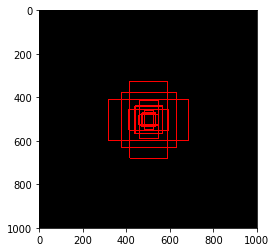

In [7]:
img = np.zeros((1000, 1000, 3))
a = generate_anchors() / 2 + [500, 500, 500, 500]
img = plot_anchors(img, a.astype(int) , (255, 0, 0), 4)
plt.imshow(img)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image

rc('animation', html='html5')

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.axis('off')

a = np.zeros((1000, 1000, 3))

im = plt.imshow(a)

def init():
    im.set_data(np.zeros((1000, 1000, 3)))
    return [im]

# animation function.  This is called sequentially
def animate(flush, i):
    a = np.zeros((1000, 1000, 3)) if flush else im.get_array()
    b = (generate_anchors() / 2) + [(i % 4 + 1) * 200, np.ceil((i + 1) / 4) * 200,
                                    (i % 4 + 1) * 200, np.ceil((i + 1) / 4) * 200]
    a = plot_anchors(a, b.astype(int) , (255, 0, 0), 4)
    im.set_array(a)
    return [im]

def anim(flush):
    return animation.FuncAnimation(fig, lambda x: animate(flush, x), init_func=init,
                                frames=16, interval=1000, blit=True);
plt.close()

In [11]:
anim(True)

W0904 13:05:36.129627 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:36.199054 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:36.259284 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:36.325801 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:36.396703 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:36.462622 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:36.525658 140467

In [12]:
anim(False)

W0904 13:05:53.178282 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:53.273629 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:53.340969 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:53.400590 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:53.468513 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:53.532450 140467440297792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 13:05:53.591629 140467

In [12]:
def iou(bboxes1: np.ndarray, bboxes2: np.ndarray) -> np.ndarray:
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    
    return iou

In [14]:
img = cv2.cvtColor(cv2.imread('../data/train/15-02-15-20:17.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (480, 480)) 

pos_s = []
neg = []

anchors_cache = []

move_anchors = lambda x, dx, dy: x + [dx, dy, dx, dy]

for dx in range(25):
    for dy in range(25):
        anchors = generate_anchors(base_size=4, ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                                   scales=2 ** np.arange(3, 10))
        anchors = move_anchors(anchors.astype(int), 20 * dx, 20 * dy)
        anchors = anchors[((anchors > 0) & (anchors < 480)).all(axis=-1), :]
        
        if anchors.any():
            anchors_cache.append(anchors)
        
        iou_matrix = iou(anchors, example)
        if iou_matrix.any():
            cache = iou_matrix
        
        pos_s.append(anchors[(iou_matrix > 0.65).any(axis=1)])
        neg.append(anchors[(iou_matrix < 0.3).all(axis=1)])

slow = set()
for i in np.concatenate(anchors_cache):
    slow.add(str(i))

In [29]:
from itertools import product

delta = 10 * np.array(list(product(range(30),range(30))))
delta = np.hstack([delta, delta])
anchors = generate_anchors(base_size=4,
                           ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                           scales=2 ** np.arange(3, 10))

anchors = anchors.reshape(-1, 4, 1) + np.zeros((*anchors.shape, delta.shape[0]))
anchors += delta.T.reshape(1, 4, -1)
anchors = anchors.transpose(2, 0, 1).reshape(-1, 4)
anchors = anchors[((anchors > 0) & (anchors < 480)).all(axis=-1), :]
iou_matrix = iou(anchors, example)
pos = anchors[(iou_matrix > 0.7).any(axis=1)]
neg = anchors[(iou_matrix < 0.3).any(axis=1)]

fast = set()
for i in anchors.astype(int):
    fast.add(str(i))

In [32]:
from vehicle_nowcasting.datasets.utils import iou as tf_iou 
tf.constant(anchors)

(-0.5, 243.5, 243.5, -0.5)

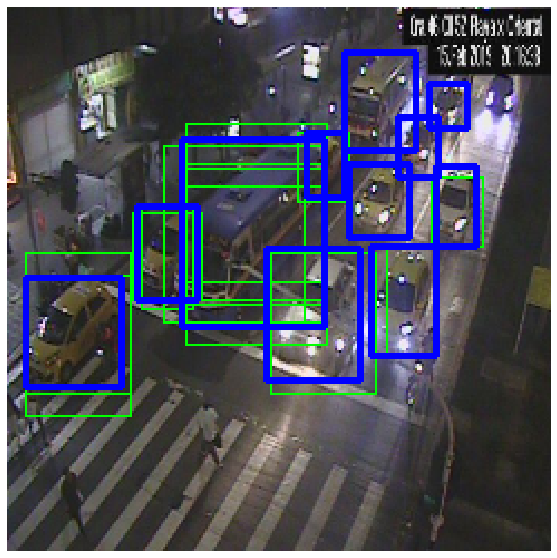

In [28]:
img = cv2.cvtColor(cv2.imread('../data/train/15-02-15-20:17.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (244, 244)) 

def plot_bb(img, org, color, size):
    for anch in org.astype(int):
        img = cv2.rectangle(img, (anch[0], anch[1]), 
                            (anch[2], anch[3]), color, size)
    return img

img = plot_bb(img, pos, (0, 255, 0), 1)
img = plot_bb(img, example, (0, 0, 255), 2)
        
plt.figure(figsize=(10, 10))
plt.imshow(img/255)
plt.axis('off')